# Entropy and Complexity of art

This notebook calculates Shanon Entropy and complexity analysis of Best Artworks of All Time dataset

In [1]:
from PIL import Image
from PIL import ImagePalette
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pickle
import matplotlib

In [2]:
import cv2

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
# Displays the loaded image  
def display_image(img):
    myimage = Image.open(img)
    return myimage

In [5]:
#Computes the array of all sliding 2x2 submatrices from a given matrix.
def create_sliding_matrices(color_array, height, width):

    matrix_array = np.zeros(shape = (height - 1, width - 1, 2, 2))
    col_mat = np.array(color_array).astype(int).reshape((height, width))
            
    for i in range(0, height - 1):
        for j in range(0, width - 1):
            matrix_array[i, j] = col_mat[np.ix_([i, i + 1],
                                                [j, j + 1])].astype(int)
    return(matrix_array)

In [6]:
#Computes the permutation associated with the 2x2 matrix.
def compute_permutation(matrix):

    permutation = np.argsort(matrix.flatten())
    return permutation

In [7]:
# Returns the distribution of matrix permutaions.
def permutataion_distribution(matrix_list):

    list_of_perm = []
    num_of_perm = []
    distribution = np.zeros(24)
    for i in matrix_list:
        mat_perm = compute_permutation(np.array(i))
        indicator = 0
        for j in range(0, len(list_of_perm)):
            if np.all(mat_perm == list_of_perm[j]):
                num_of_perm[j] = num_of_perm[j] + 1
                indicator = 1
        if indicator == 0:
            list_of_perm.append(mat_perm)
            num_of_perm.append(1)
            
    distribution = np.array(num_of_perm) / sum(num_of_perm)
    return num_of_perm, list_of_perm, distribution
    

## Entropy and Complexity

 two parameters which are evaluated for each painting.  Shannon Entropy:
$$
S(P) = \sum_{i = 0}^{n} p_i \ln{(1/p_i)}
$$

In [8]:
#Compute Shannon entropy 
def compute_entropy(distribution):
    Shannon_entropy = -np.sum(distribution * np.log2(distribution))
    return Shannon_entropy

Normalised Shannon entropy : 
$$
H(P) = 
\frac{1}{\ln{n}} \sum_{i = 0}^{n} p_i \ln{(1/p_i)}
$$

In [9]:
#Compute normalised Shannon entropy
def normalise_entropy(distribution):
    Shannon_norm = -np.sum(distribution * np.log2(distribution)) / np.log2(len(distribution))
    return Shannon_norm

The second parameter, complexity:

$$
C(P) = \frac{D(P, U) H(P)}{D^*}
$$

$$
D(P,U) = S\left( \frac{P+U}{2} \right) - \frac{S(P)}{2} - \frac{S(U)}{2}
$$

$$
D^* = \max_P{D(P,U)} = - \frac{1}{2} \left[ \frac{n+1}{n} \ln{(n+1)} + \ln{(n) - 2\ln{(2n)}} \right]
$$

In [10]:
#Statistical Complexity from distribution
def compute_complexity(distribution):
    comp = compute_divergence(distribution) * normalise_entropy(distribution) / find_norm_constant(distribution)
    return comp

In [11]:
#Jensen-Shannon divergence
def compute_divergence(distribution):
    n = len(distribution)
    uniform = np.array([1/n] * n)
    div = compute_entropy((distribution + uniform)/2) - compute_entropy(distribution)/2 - compute_entropy(uniform)/2
    return div

In [12]:
#Normalisation constant D*
def find_norm_constant(distribution):
    n = len(distribution)
    const = -0.5 * (((n + 1) / n) * np.log(n + 1) + np.log(n) - 2 * np.log(2 * n))
    return const

In [13]:
def produce_entropy_complexity(name):

    img1 = cv2.imread(name)
    myimage = display_image(name)
    
    painting_width, painting_height = myimage.size
    b, g, r = cv2.split(img1)
    
    b = pd.Series(b.flatten(), dtype='int')
    g = pd.Series(g.flatten(), dtype='int')
    r = pd.Series(r.flatten(), dtype='int')
    
    mean_channel = (b + g + r)/3
    sliding_matrix = create_sliding_matrices(mean_channel,
                                             painting_height,
                                             painting_width).reshape(((painting_height - 1) * (painting_width-1),
                                             2,
                                             2))
    res1 = permutataion_distribution(sliding_matrix)
    entr = normalise_entropy(res1[2])
    compl = compute_complexity(res1[2])

    return entr, compl

# Data

The collection of paintings used in this project is from Best Artworks of All Time dataset.
https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time

In [14]:
df = pd.read_csv(r'archive/artists.csv')

In [15]:
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [16]:
artitst_name=np.unique(df['name'])
artitst_name

array(['Albrecht Dürer', 'Alfred Sisley', 'Amedeo Modigliani',
       'Andrei Rublev', 'Andy Warhol', 'Camille Pissarro', 'Caravaggio',
       'Claude Monet', 'Diego Rivera', 'Diego Velazquez', 'Edgar Degas',
       'Edouard Manet', 'Edvard Munch', 'El Greco', 'Eugene Delacroix',
       'Francisco Goya', 'Frida Kahlo', 'Georges Seurat',
       'Giotto di Bondone', 'Gustav Klimt', 'Gustave Courbet',
       'Henri Matisse', 'Henri Rousseau', 'Henri de Toulouse-Lautrec',
       'Hieronymus Bosch', 'Jackson Pollock', 'Jan van Eyck', 'Joan Miro',
       'Kazimir Malevich', 'Leonardo da Vinci', 'Marc Chagall',
       'Michelangelo', 'Mikhail Vrubel', 'Pablo Picasso', 'Paul Cezanne',
       'Paul Gauguin', 'Paul Klee', 'Peter Paul Rubens',
       'Pierre-Auguste Renoir', 'Piet Mondrian', 'Pieter Bruegel',
       'Raphael', 'Rembrandt', 'Rene Magritte', 'Salvador Dali',
       'Sandro Botticelli', 'Titian', 'Vasiliy Kandinskiy',
       'Vincent van Gogh', 'William Turner'], dtype=object)

In [17]:

df['name'] = df['name'].str.replace(' ', '_')

In [18]:
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo_Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy_Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego_Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude_Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene_Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [19]:
import os


In [20]:
from tqdm import tqdm, trange

In [21]:

new_df = pd.DataFrame(columns=['Artist', 'Art', 'Entropy', 'Complexity','Year','Year_AVG'],)

In [22]:
parent_path = os.listdir("archive/resized/resized/")
#j=0
for artist_name in tqdm(df["name"]):
    #if j > 3:
     #       break
    #j += 1
    result = []
    for file in parent_path:
        if file.startswith(artist_name):
            result.append(file)
    #i=0
    for file in result:
        [entropy, complexity] = produce_entropy_complexity('archive/resized/resized/'+ file)
        row = {
            "Artist": artist_name,
            "Art": file,
            "Entropy": entropy,
            "Complexity": complexity,
            "Year": df.loc[df['name'] == artist_name, 'years'].iloc[0],
            "Year_AVG": 0
                }

        new_df = new_df.append(row, ignore_index=True)
       
       
       # if i > 10:
        #    break
       # i += 1

  0%|                                                    | 0/50 [00:00<?, ?it/s]/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is 

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
 16%|██████▌                                  | 8/50 [34:12<3:11:31, 273.61s/it]/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is 

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
 26%|██████████▍                             | 13/50 [58:30<2:42:28, 263.47s/it]/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is 

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
 54%|████████████████████▌                 | 27/50 [3:01:29<2:45:41, 432.26s/it]/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is 

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

 64%|████████████████████████▎             | 32/50 [3:24:41<1:39:05, 330.30s/it]/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is 

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
 80%|████████████████████████████████        | 40/50 [3:58:13<35:17, 211.79s/it]/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is 

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
 90%|████████████████████████████████████    | 45/50 [4:10:27<13:32, 162.59s/it]/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is 

/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(row, ignore_index=True)
/var/folders/h1/ccdnpmhj1qx1v5zdbsj0gk6r0000gn/T/ipykernel_64359/1899171671.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conca

In [29]:
new_df

,Artist,Art,Entropy,Complexity,Year,Year_AVG
0,Amedeo_Modigliani,Amedeo_Modigliani_24.jpg,0.950491,0.091421,1884 - 1920,0
1,Amedeo_Modigliani,Amedeo_Modigliani_30.jpg,0.954252,0.084433,1884 - 1920,0
2,Amedeo_Modigliani,Amedeo_Modigliani_18.jpg,0.939379,0.109580,1884 - 1920,0
3,Amedeo_Modigliani,Amedeo_Modigliani_184.jpg,0.968081,0.059660,1884 - 1920,0
4,Amedeo_Modigliani,Amedeo_Modigliani_190.jpg,0.932895,0.121095,1884 - 1920,0
...,...,...,...,...,...,...
583,Jackson_Pollock,Jackson_Pollock_20.jpg,0.988253,0.022396,1912 – 1956,0
584,Jackson_Pollock,Jackson_Pollock_1.jpg,0.990831,0.017528,1912 – 1956,0
585,Jackson_Pollock,Jackson_Pollock_21.jpg,0.972212,0.052423,1912 – 1956,0
586,Jackson_Pollock,Jackson_Pollock_23.jpg,0.964978,0.064560,1912 – 1956,0


In [31]:
new_df_copy = new_df.copy()

In [33]:

new_df_copy.to_csv('output.csv')

In [53]:
output_df = pd.read_csv(r'output.csv')

In [54]:
output_df

,Unnamed: 0,Artist,Art,Entropy,Complexity,Year,Year_AVG
0,0,Amedeo_Modigliani,Amedeo_Modigliani_24.jpg,0.950491,0.091421,1884 - 1920,0
1,1,Amedeo_Modigliani,Amedeo_Modigliani_30.jpg,0.954252,0.084433,1884 - 1920,0
2,2,Amedeo_Modigliani,Amedeo_Modigliani_18.jpg,0.939379,0.109580,1884 - 1920,0
3,3,Amedeo_Modigliani,Amedeo_Modigliani_184.jpg,0.968081,0.059660,1884 - 1920,0
4,4,Amedeo_Modigliani,Amedeo_Modigliani_190.jpg,0.932895,0.121095,1884 - 1920,0
...,...,...,...,...,...,...,...
583,583,Jackson_Pollock,Jackson_Pollock_20.jpg,0.988253,0.022396,1912 - 1956,0
584,584,Jackson_Pollock,Jackson_Pollock_1.jpg,0.990831,0.017528,1912 - 1956,0
585,585,Jackson_Pollock,Jackson_Pollock_21.jpg,0.972212,0.052423,1912 - 1956,0
586,586,Jackson_Pollock,Jackson_Pollock_23.jpg,0.964978,0.064560,1912 - 1956,0


In [55]:

output_df['Year_AVG'] = output_df['Year'].apply(lambda x: int((int(x.split('-')[0]) + int(x.split('-')[1])) /2))
output_df

,Unnamed: 0,Artist,Art,Entropy,Complexity,Year,Year_AVG
0,0,Amedeo_Modigliani,Amedeo_Modigliani_24.jpg,0.950491,0.091421,1884 - 1920,1902
1,1,Amedeo_Modigliani,Amedeo_Modigliani_30.jpg,0.954252,0.084433,1884 - 1920,1902
2,2,Amedeo_Modigliani,Amedeo_Modigliani_18.jpg,0.939379,0.109580,1884 - 1920,1902
3,3,Amedeo_Modigliani,Amedeo_Modigliani_184.jpg,0.968081,0.059660,1884 - 1920,1902
4,4,Amedeo_Modigliani,Amedeo_Modigliani_190.jpg,0.932895,0.121095,1884 - 1920,1902
...,...,...,...,...,...,...,...
583,583,Jackson_Pollock,Jackson_Pollock_20.jpg,0.988253,0.022396,1912 - 1956,1934
584,584,Jackson_Pollock,Jackson_Pollock_1.jpg,0.990831,0.017528,1912 - 1956,1934
585,585,Jackson_Pollock,Jackson_Pollock_21.jpg,0.972212,0.052423,1912 - 1956,1934
586,586,Jackson_Pollock,Jackson_Pollock_23.jpg,0.964978,0.064560,1912 - 1956,1934


In [56]:
colors = matplotlib.cm.rainbow(np.linspace(np.min(output_df['Year_AVG']), np.max(output_df['Year_AVG']), 10))

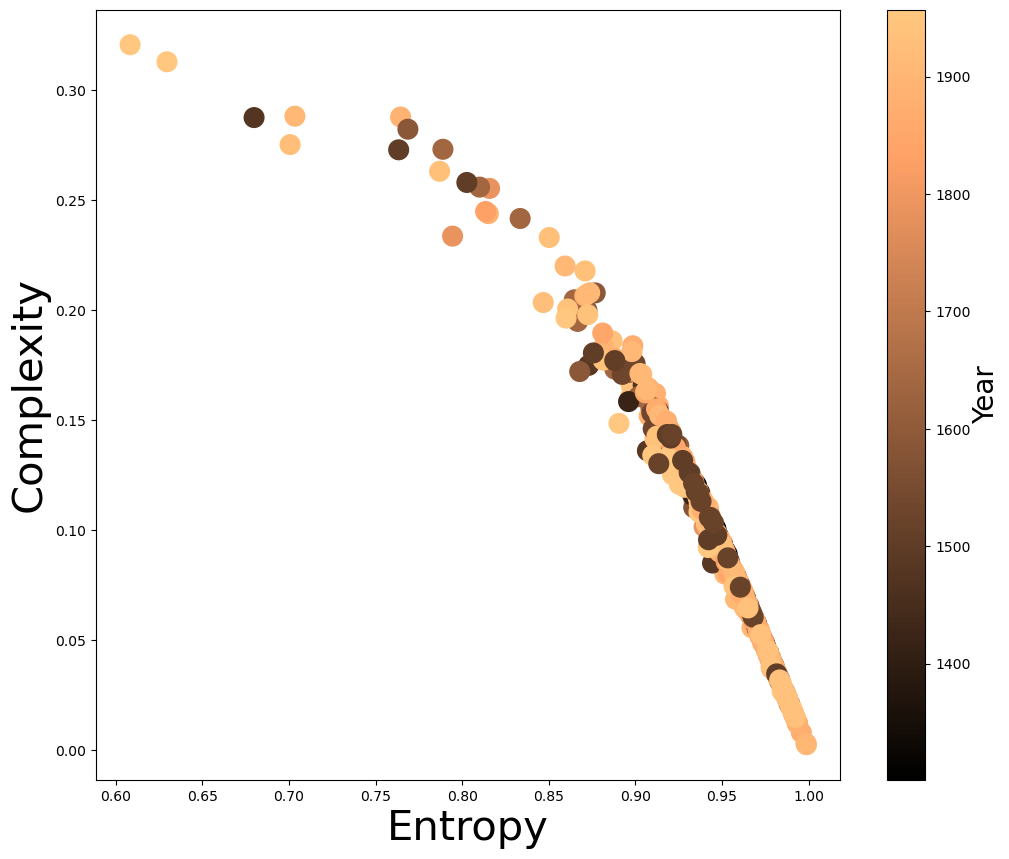

In [57]:
plt.figure(figsize = (12,10))

plt.xlabel('Entropy', fontsize = 30)
plt.ylabel('Complexity', fontsize = 30)

plt.scatter(output_df['Entropy'], output_df['Complexity'], c = output_df['Year_AVG'], cmap=plt.cm.copper, s = 200)
cbar= plt.colorbar()
cbar.set_label("Year", labelpad=+1, fontsize = 20)

In this figure, each dot represents a piece of artwork on the complexity-entropy axes. The colors of the dots coordinate with the time period in which they were made. Here we find a trend that holds true to the thermodynamic patterning: As entropy approaches maximum disorder, the complexity of the artwork diminishes. The slope concaves downward; the slope continues to decrease meaning for every unit of entropy increasing, the complexity plumets more. Interestingly, we also see some grouping in time periods of when artwork is produced. Modern and post-modern art of 1800 and beyond tends to be concentrated in higher entropy and lower complexity, while the renaissance and classic art of pre-1800 tend to be closer to the middle.
With these trends, we can see that the patten of artwork on the complexity-entropy axes is clear. 